# Process FASTA files
- create theoretically considered peptides considere by search engines
- dump results

> Based on notebook received by [Annelaura Bach](https://www.cpr.ku.dk/staff/mann-group/?pure=en/persons/443836) and created by Johannes B. Müller \[[scholar](https://scholar.google.com/citations?user=Rn1OS8oAAAAJ&hl=de), [MPI Biochemistry](https://www.biochem.mpg.de/person/93696/2253)\]

In [1]:
import json
import logging
import os

import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
from vaep.fasta import cleave_to_tryptic

## Core Functionality - Example

- write tests for core functinality
- refactor to file

In [3]:
test_data = {
    "meta": ">tr|A0A024R1R8|A0A024R1R8_HUMAN HCG2014768, isoform CRA_a OS=Homo sapiens OX=9606 GN=hCG_2014768 PE=4 SV=1",
    "seq": "MSSHEGGKKKALKQPKKQAKEMDEEEKAFKQKQKEEQKKLEVLKAKVVGKGPLATGGIKKSGKK",
    "peptides": ["MSSHEGGK", "EMDEEEK", "GPLATGGIK"],
}

regex is slower than native string replacing and splitting in Python

In [4]:
# import re
# cut_by_trypsin = re.compile('([^K]+K)|([^R]+R)')
# _res = cut_by_trypsin.split(test_data['seq'])
# [_pep for _pep in _res if _pep != '' and _pep != None]


- map peptide set of peptides (how to deal with mis-cleavages?)
    - mis-cleavages can happen both to the peptide before and after.
    > `pep1, pep2, pep3, pep4, pep5`  
    > `pep1pep2, pep2pep3, pep3pep4, pep4pep5`
    - sliding windows can pass trough the list of peptides - should work with recursion

In [5]:
l_peptides = test_data["seq"].replace("K", "K ").replace("R", "R ").split()
l_peptides

['MSSHEGGK',
 'K',
 'K',
 'ALK',
 'QPK',
 'K',
 'QAK',
 'EMDEEEK',
 'AFK',
 'QK',
 'QK',
 'EEQK',
 'K',
 'LEVLK',
 'AK',
 'VVGK',
 'GPLATGGIK',
 'K',
 'SGK',
 'K']

`add_rxk` should add pattern of starting R and trailing K ?  

In [6]:
last_pep = ""
temp_peps = []
num_missed_cleavages = 1
add_rxk = True

sec_last_pep = ""

pep_rdx = []

for pep in l_peptides:
    if last_pep != "":
        temp_peps.append(last_pep + pep)
    if add_rxk and sec_last_pep != "" and len(sec_last_pep) <= 2:
        _pep_rxk = sec_last_pep + last_pep + pep
        print(_pep_rxk)
        pep_rdx.append(_pep_rxk)
        temp_peps.append(_pep_rxk)

    sec_last_pep = last_pep  # sec_last_pep, last_pep = last_pep, pep ?
    last_pep = pep
temp_peps

KKALK
KALKQPK
KQAKEMDEEEK
QKQKEEQK
QKEEQKK
KLEVLKAK
AKVVGKGPLATGGIK
KSGKK


['MSSHEGGKK',
 'KK',
 'KALK',
 'KKALK',
 'ALKQPK',
 'KALKQPK',
 'QPKK',
 'KQAK',
 'QAKEMDEEEK',
 'KQAKEMDEEEK',
 'EMDEEEKAFK',
 'AFKQK',
 'QKQK',
 'QKEEQK',
 'QKQKEEQK',
 'EEQKK',
 'QKEEQKK',
 'KLEVLK',
 'LEVLKAK',
 'KLEVLKAK',
 'AKVVGK',
 'VVGKGPLATGGIK',
 'AKVVGKGPLATGGIK',
 'GPLATGGIKK',
 'KSGK',
 'SGKK',
 'KSGKK']

In [7]:
repr(pep_rdx)

"['KKALK', 'KALKQPK', 'KQAKEMDEEEK', 'QKQKEEQK', 'QKEEQKK', 'KLEVLKAK', 'AKVVGKGPLATGGIK', 'KSGKK']"

Missed cleavages core functionality (adapted)

In [8]:
example_peptides_fasta = cleave_to_tryptic(
    test_data["seq"], num_missed_cleavages=2, add_rxk=True
)
print("number of peptides: ", [len(_l) for _l in example_peptides_fasta])
example_peptides_fasta[-1]

number of peptides:  [20, 19, 18]


['MSSHEGGKKK',
 'KKALK',
 'KALKQPK',
 'ALKQPKK',
 'QPKKQAK',
 'KQAKEMDEEEK',
 'QAKEMDEEEKAFK',
 'EMDEEEKAFKQK',
 'AFKQKQK',
 'QKQKEEQK',
 'QKEEQKK',
 'EEQKKLEVLK',
 'KLEVLKAK',
 'LEVLKAKVVGK',
 'AKVVGKGPLATGGIK',
 'VVGKGPLATGGIKK',
 'GPLATGGIKKSGK',
 'KSGKK']

In [9]:
print("".join(example_peptides_fasta[0]), *example_peptides_fasta, sep="\n")

MSSHEGGKKKALKQPKKQAKEMDEEEKAFKQKQKEEQKKLEVLKAKVVGKGPLATGGIKKSGKK
['MSSHEGGK', 'K', 'K', 'ALK', 'QPK', 'K', 'QAK', 'EMDEEEK', 'AFK', 'QK', 'QK', 'EEQK', 'K', 'LEVLK', 'AK', 'VVGK', 'GPLATGGIK', 'K', 'SGK', 'K']
['MSSHEGGKK', 'KK', 'KALK', 'ALKQPK', 'QPKK', 'KQAK', 'QAKEMDEEEK', 'EMDEEEKAFK', 'AFKQK', 'QKQK', 'QKEEQK', 'EEQKK', 'KLEVLK', 'LEVLKAK', 'AKVVGK', 'VVGKGPLATGGIK', 'GPLATGGIKK', 'KSGK', 'SGKK']
['MSSHEGGKKK', 'KKALK', 'KALKQPK', 'ALKQPKK', 'QPKKQAK', 'KQAKEMDEEEK', 'QAKEMDEEEKAFK', 'EMDEEEKAFKQK', 'AFKQKQK', 'QKQKEEQK', 'QKEEQKK', 'EEQKKLEVLK', 'KLEVLKAK', 'LEVLKAKVVGK', 'AKVVGKGPLATGGIK', 'VVGKGPLATGGIKK', 'GPLATGGIKKSGK', 'KSGKK']


rdx peptides are a subset of two missed cleavage sites peptides. There are omitted when two and more cleavage site can be skipped.

In [10]:
example_peptides_fasta = cleave_to_tryptic(
    test_data["seq"], num_missed_cleavages=1, add_rxk=True
)
print("number of peptides: ", [len(_l) for _l in example_peptides_fasta])
example_peptides_fasta[-1]

number of peptides:  [20, 19, 8]


['KKALK',
 'KALKQPK',
 'KQAKEMDEEEK',
 'QKQKEEQK',
 'QKEEQKK',
 'KLEVLKAK',
 'AKVVGKGPLATGGIK',
 'KSGKK']

Data Structure is no a list of list. Maybe this could be improved. Information what kind of type the peptide is from, is still interesting.

### Original Code

now adapted in `vaep.fasta.py`

In [11]:
# def cleave_to_tryptic(seq="", num_missed_cleavages=1, reversed=False):
# #    Takes a sequence and returns an array of peptides cleaved C-term to R  and K
# #    number of missed cleavages can be 0 or 1
# #    works with single letter sequences
# #    :param seq:
# #    num_missed_cleavges,
# #    reversed: boolean flag. If true, append the reversed peptide spequences as well
# #    :return: list of strings
#     if  0 < num_missed_cleavages > 2:
#         raise NotImplementedError("`num_missed_cleavages` of missed cleavages can be 0 or 1")
#     if seq == "":
#         return
#     add_rxk = True  # flag for adding bonus peptides at patterns like KXR, which trypsin doesn't cleave efficiently

#     seq.replace(' ', '')  # sequence must not contain whitespaces todo: all whitespaces
#     seq = seq.upper()
#     seq = seq.replace('K', 'K ').replace('R', 'R ')  # introduce a white space so we can split there
#     pep_seqs = seq.split()

#     last_pep = ""
#     temp_peps = []
#     if num_missed_cleavages == 0 and add_rxk:
#         for pep in pep_seqs:
#             if 0 < len(last_pep) <= 2:
#                 temp_peps.append(last_pep+pep)
#             last_pep = pep
#         pep_seqs += temp_peps

#     sec_last_pep = ""


#     if num_missed_cleavages == 1:  # add joined peptides
#         for pep in pep_seqs:
#             if last_pep != "":
#                 temp_peps.append(last_pep + pep)
#             if add_rxk and sec_last_pep != "" and len(sec_last_pep) <= 2:
#                 temp_peps.append(sec_last_pep + last_pep + pep)
#             sec_last_pep = last_pep  # sec_last_pep, last_pep = last_pep, pep ?
#             last_pep = pep
#         pep_seqs += temp_peps
#     # # if num_missed_cleavages == 2: todo: implement two missed cleavages
#     # # add recursion to build peptides iteratively while iterating through peptide sequences


#     if reversed:
#         reversed_seqs = []
#         for pep in pep_seqs:
#             if str(pep).endswith('K'):  # change this to change the MW of the peptide
#                 pep = pep[0:-1] + 'r'
#             elif str(pep).endswith('R'):
#                 pep = pep[0:-1] + 'k'
#             rev_pep = pep[::-1]
#             reversed_seqs.append(rev_pep)

#         pep_seqs += reversed_seqs

#     return pep_seqs

Header is used to distinguish new entries in fasta files:

In [12]:
# # #ToDo: Check if file-reader
# def read_fasta(fp):
#     """Read a fasta file and yield continously header and sequences."""
#     header, seq = None, []
#     for line in fp:
#         line = line.rstrip()
#         if line.startswith(">"):
#             if header: yield (header, ''.join(seq))
#             header, seq = line, []
#         else:
#             seq.append(line)
#     if header: yield (header, ''.join(seq))

Flattens a list of list using generators:

In [13]:
# def iterFlatten(root):
#     """Flatten a nested structure."""
#     if isinstance(root, (list, tuple)):
#         for element in root:
#             for e in iterFlatten(element):
#                 yield e
#     else:
#         yield root

## Process Fasta Files

First define input Folder and the file location of the created peptides:

In [14]:
from src.file_utils import search_files

fasta_files = search_files(path=".", query=".fasta")
print("\n".join(fasta_files.files))

data\fasta\UP000005640_9606.fasta
data\fasta\UP000005640_9606_additional.fasta


### Define Setup

Set input FASTA, Output .txt name, lower legth cutoff, missed cleavages and if to report reverse. 

Tryptic digest of Fastas to Peptides >6 in list for matching with measured peptides  

In [15]:
CUTOFF_LEN_PEP = 7
MAX_MISSED_CLEAVAGES = 2  # default in MaxQuant
DECOY_REVERSE = False
SUMMARY_FILE = "tex/fasta_tryptic_analysis.tex"

_summary_text = (
    "The theoretical analysis of the fasta files gives an idea about how many possible peptides \n"
    "can be expected by cleaving proteins by peptides. The hyperparameters for peptide creation are \n"
    f"to consider the minimal peptide length to be {CUTOFF_LEN_PEP} amino acids, \n"
    f"to consider a maximum of {MAX_MISSED_CLEAVAGES} missed cleavage sites (default in MaxQuant) and \n"
    f"to {'not ' if not DECOY_REVERSE else ''}add decoy peptides by reversing peptide sequences. \n"
)
print(_summary_text, sep="\n")

The theoretical analysis of the fasta files gives an idea about how many possible peptides 
can be expected by cleaving proteins by peptides. The hyperparameters for peptide creation are 
to consider the minimal peptide length to be 7 amino acids, 
to consider a maximum of 2 missed cleavage sites (default in MaxQuant) and 
to not add decoy peptides by reversing peptide sequences. 



From the [Fasta Meta information](https://ebi14.uniprot.org/help/fasta-headers) the Identifier is extracted.

```
>db|UniqueIdentifier|EntryName ProteinName OS=OrganismName OX=OrganismIdentifier [GN=GeneName ]PE=ProteinExistence SV=SequenceVersion
```
- db is `sp` for UniProtKB/Swiss-Prot and `tr` for UniProtKB/TrEMBL.
- `UniqueIdentifier` is the primary *accession number* of the UniProtKB entry. (seems to be used by MQ)
- `EntryName` is the entry name of the UniProtKB entry.
- `ProteinName` is the recommended name of the UniProtKB entry as annotated in the *RecName* field. For UniProtKB/TrEMBL entries without a *RecName* field, the *SubName* field is used. In case of multiple SubNames, the first one is used. The 'precursor' attribute is excluded, 'Fragment' is included with the name if applicable.

`>tr` or `>sp`

In [16]:
from vaep.fasta import read_fasta

data_fasta = {}

for _fasta in tqdm(fasta_files.files):

    with open(_fasta) as fp:
        for i, (metainfo, seq) in tqdm(enumerate(read_fasta(fp))):
            identifier = metainfo.split("|")[1]
            if identifier in data_fasta:
                raise ValueError("Key seen before: {}".format(identifier))
            _all_peptides = cleave_to_tryptic(
                seq, num_missed_cleavages=MAX_MISSED_CLEAVAGES, reversed=DECOY_REVERSE
            )
            data_fasta[identifier] = {
                "meta": metainfo,
                "seq": seq,
                "peptides": [
                    [_pep for _pep in _peptides if len(_pep) >= CUTOFF_LEN_PEP]
                    for _peptides in _all_peptides
                ],
            }

`fasta_data` holds all information to pick a subset of peptides from peptides intensity tables

In [17]:
# from random import sample
# sample_ids = sample(list(data_fasta), 10)
# for _id in sample_ids:
#     print("Unique Identifier: {}: \n\t AA-Seq: {} \n\t Header: {} \n\t Peptides: {}\n".format(_id, data_fasta[_id]['seq'], data_fasta[_id]['meta'], data_fasta[_id]['peptides']))
data_fasta["A0A024R1R8"]

{'meta': '>tr|A0A024R1R8|A0A024R1R8_HUMAN HCG2014768, isoform CRA_a OS=Homo sapiens OX=9606 GN=hCG_2014768 PE=4 SV=1',
 'seq': 'MSSHEGGKKKALKQPKKQAKEMDEEEKAFKQKQKEEQKKLEVLKAKVVGKGPLATGGIKKSGKK',
 'peptides': [['MSSHEGGK', 'EMDEEEK', 'GPLATGGIK'],
  ['MSSHEGGKK',
   'QAKEMDEEEK',
   'EMDEEEKAFK',
   'LEVLKAK',
   'VVGKGPLATGGIK',
   'GPLATGGIKK'],
  ['MSSHEGGKKK',
   'KALKQPK',
   'ALKQPKK',
   'QPKKQAK',
   'KQAKEMDEEEK',
   'QAKEMDEEEKAFK',
   'EMDEEEKAFKQK',
   'AFKQKQK',
   'QKQKEEQK',
   'QKEEQKK',
   'EEQKKLEVLK',
   'KLEVLKAK',
   'LEVLKAKVVGK',
   'AKVVGKGPLATGGIK',
   'VVGKGPLATGGIKK',
   'GPLATGGIKKSGK']]}

### Proteins' Isoforms

Possible to join "isoforms" by joining all variants to one. Isoforms are numbered from the second on by appending `-i` for $i>1$, i.e. starting with `-2`. The gene name of which the protein (isoform) originate can be obtained by using [id mapping](https://www.uniprot.org/help/api_idmapping). Isoforms are not mapped automatically by Uniprot to its GENENAME, i.e. you have to strip all `-i`, e.g `-2`, `-3`, for querying. Here the protein, gene pairs are mapped to the unique protein identifiers.

In [18]:
prot_ids = list(data_fasta.keys())
prot_ids = pd.Series(prot_ids)
prot_ids

0        A0A024R1R8
1        A0A024RBG1
2        A0A075B6H5
3        A0A075B6H7
4        A0A075B6H8
            ...    
96413        U3KQU4
96414        V9GXZ4
96415        V9GYD0
96416        V9GYS4
96417        V9GZ69
Length: 96418, dtype: object

In [19]:
mask = prot_ids.str.contains("-")
isoforms = prot_ids.copy().loc[mask]
isoforms

23363    A0A096LP49-2
24288    A0A0B4J2D5-2
26264    A0A0K2S4Q6-2
26652    A0A140G945-2
27673    A0A1B0GVQ0-2
             ...     
94596        Q9Y6Y9-2
94597        Q9Y6Z4-2
94598        Q9Y6Z5-2
95829        W5XKT8-2
95830        W5XKT8-3
Length: 22002, dtype: object

In [20]:
N_prot_with_isoform = isoforms.str.split("-").str[0].nunique()

In [21]:
n_unique_proteins_wo_isoforms = len(prot_ids) - len(isoforms)
_summary_text += "\nA total of {} proteins have at least one more isoform. ".format(
    N_prot_with_isoform
)
_summary_text += f"Collapsing isoforms into one protein results in {n_unique_proteins_wo_isoforms} proteins."
print(_summary_text)

The theoretical analysis of the fasta files gives an idea about how many possible peptides 
can be expected by cleaving proteins by peptides. The hyperparameters for peptide creation are 
to consider the minimal peptide length to be 7 amino acids, 
to consider a maximum of 2 missed cleavage sites (default in MaxQuant) and 
to not add decoy peptides by reversing peptide sequences. 

A total of 10534 proteins have at least one more isoform. Collapsing isoforms into one protein results in 74416 proteins.


Remove Isoforms from list. How to integrate this information before?

fasta-data has to be merge one-to-many.

In [22]:
id_map = pd.DataFrame(
    prot_ids.str.split("-").str[0], columns=["protein"]
)  # , index=list(prot_ids))
id_map.index = pd.Index(prot_ids, name="prot_id")
id_map

,protein
prot_id,
A0A024R1R8,A0A024R1R8
A0A024RBG1,A0A024RBG1
A0A075B6H5,A0A075B6H5
A0A075B6H7,A0A075B6H7
A0A075B6H8,A0A075B6H8
...,...
U3KQU4,U3KQU4
V9GXZ4,V9GXZ4
V9GYD0,V9GYD0


In [23]:
id_map.loc[id_map.index.str.contains("A0A096LP49|Q9Y6Z5|W5XKT8")]

,protein
prot_id,
A0A096LP49,A0A096LP49
Q9Y6Z5,Q9Y6Z5
W5XKT8,W5XKT8
A0A096LP49-2,A0A096LP49
Q9Y6Z5-2,Q9Y6Z5
W5XKT8-2,W5XKT8
W5XKT8-3,W5XKT8


In [24]:
l_proteins = id_map.protein.unique()
print(
    f"There are {len(l_proteins)} unique proteins without isoforms listed in the used fasta files."
)
# Check with pervious result.
assert n_unique_proteins_wo_isoforms == len(l_proteins)

There are 74416 unique proteins without isoforms listed in the used fasta files.


In [25]:
from config import FN_PROT_GENE_MAP

from vaep.uniprot import query_uniprot_id_mapping

try:
    with open(FN_PROT_GENE_MAP) as f:
        dict_protein_to_gene = json.load(f)
    logging.warning(f"Loaded pre-cached map dict_protein_to_gene: {FN_PROT_GENE_MAP}")
except FileNotFoundError:
    dict_protein_to_gene = {}
    start = 0
    for end in list(range(10000, len(l_proteins), 10000)):
        print(f"Retrieve items {start+1:6} to {end:6}")
        _id_to_gene = query_uniprot_id_mapping(l_proteins[start:end])
        print(f"Found {len(_id_to_gene)} gene names")
        dict_protein_to_gene.update(_id_to_gene)
        start = end
    print(f"Retrieve items {start:6} to {len(l_proteins):6}")
    _id_to_gene = query_uniprot_id_mapping(l_proteins[start:])
    print(f"Found {len(_id_to_gene)} gene names")
    dict_protein_to_gene.update(_id_to_gene)
    with open(FN_PROT_GENE_MAP, "w") as f:
        json.dump(dict_protein_to_gene, f, indent=4, sort_keys=False)

In [26]:
genes = pd.Series(dict_protein_to_gene, name="gene")
genes

A0A024R1R8    hCG_2014768
A0A024RBG1         NUDT4B
A0A075B6H5    TRBV20OR9-2
A0A075B6H7        IGKV3-7
A0A075B6H8      IGKV1D-42
                 ...     
S4R3N1         HSPE1-MOB4
S4R434        TLCD4-RWDD3
U3KQ54         PMF1-BGLAP
V9GXZ4        FPGT-TNNI3K
V9GYD0         ARL2-SNX15
Name: gene, Length: 72473, dtype: object

In [27]:
assert (
    len(genes) == 72473
), f"The number of proteins associated to a gene found on 22.09.2020 was 72473, not it's {len(genes)}"

In [28]:
id_map = id_map.merge(genes, how="outer", left_on="protein", right_index=True)
id_map.sort_values(by=["gene", "protein"], inplace=True)
id_map

,protein,gene
prot_id,,
M0R009,M0R009,A1BG
P04217,P04217,A1BG
P04217-2,P04217,A1BG
F8W9F8,F8W9F8,A1CF
Q5T0W7,Q5T0W7,A1CF
...,...,...
X6R787,X6R787,NaN
X6R8Y7,X6R8Y7,NaN
X6RBE4,X6RBE4,NaN


In [29]:
mask_no_gene = id_map.gene.isna()
id_map.loc[mask_no_gene]

,protein,gene
prot_id,,
A0A024R341,A0A024R341,NaN
A0A024R368,A0A024R368,NaN
A0A024R442,A0A024R442,NaN
A0A075B6Q4,A0A075B6Q4,NaN
A0A075B6Q7,A0A075B6Q7,NaN
...,...,...
X6R787,X6R787,NaN
X6R8Y7,X6R8Y7,NaN
X6RBE4,X6RBE4,NaN


In [30]:
_summary_text += (
    f"\nThere are {id_map.gene.isna().sum()} protein IDs (or {id_map.loc[mask_no_gene].protein.nunique()} proteins) "
    "without a gene associated to them in the current faste files."
)
print(_summary_text)

The theoretical analysis of the fasta files gives an idea about how many possible peptides 
can be expected by cleaving proteins by peptides. The hyperparameters for peptide creation are 
to consider the minimal peptide length to be 7 amino acids, 
to consider a maximum of 2 missed cleavage sites (default in MaxQuant) and 
to not add decoy peptides by reversing peptide sequences. 

A total of 10534 proteins have at least one more isoform. Collapsing isoforms into one protein results in 74416 proteins.
There are 1948 protein IDs (or 1943 proteins) without a gene associated to them in the current faste files.


### Isotopes mapping

Isotopes are mapped now to a protein with the same name. The same can be achieved by just discarding everything behind the hypen `-`

In [31]:
id_map.loc[id_map.index.str.contains("-")]

,protein,gene
prot_id,,
P04217-2,P04217,A1BG
Q9NQ94-2,Q9NQ94,A1CF
Q9NQ94-3,Q9NQ94,A1CF
Q9NQ94-4,Q9NQ94,A1CF
Q9NQ94-5,Q9NQ94,A1CF
...,...,...
A8MWP6-2,A8MWP6,NaN
A8MXK9-2,A8MXK9,NaN
Q4G0T1-2,Q4G0T1,NaN


Save id_map

In [32]:
from config import FN_ID_MAP

id_map.to_json(FN_ID_MAP, orient="split", indent=4)

### Most proteins with a missing gene are deleted

If one checks manually some of the examples (e.g. the hundred provided here), one sees that all are deleted from Uniprot.

> How to obtain different versions of UniProt?!

In [33]:
from vaep.utils import sample_iterable

if not len(dict_protein_to_gene) == len(l_proteins):
    print("Not all ids are mapped.")
    _diff = set(l_proteins).difference(dict_protein_to_gene.keys())
    print(f"Number of protein identifiers not mapped to a gene: {len(_diff)}")
    print(f'Look at {100} examples: {", ".join(sample_iterable(_diff, 100))}')

Not all ids are mapped.
Number of protein identifiers not mapped to a gene: 1943
Look at 100 examples: M0QYT0, A0A1B0GWB0, A0A3B3IT34, A0A0G2JM26, Q6AWC8, A0A2R8Y7P6, A0A2R8Y7U2, A0A2R8Y7B1, Q6ZT83, M0QZU9, A0A3B3IS89, A0A1B0GUR6, A0A1W2PQ90, A0A096LPE4, E7EPS2, H0YD56, A0A1W2PQD6, Q6JHZ5, A0A087WZA7, A0A2R8Y5N2, A0A286YES4, A0A0A6YYK5, A0A494C014, A0A494C0Y4, A8MUU9, K7EIZ5, Q4VXT4, Q6ZTK2, A8MUL9, B5MEG5, H7C4B7, G3V2T6, A0A2R8Y7E7, A0A0A0MT77, E7ERM8, K7ERU9, A0A2R8Y5H9, H0YKR5, A0A2R8Y6R3, A0A0D9SFL9, A0A2R8Y717, A0A2R8Y5W7, A0A2R8Y7I0, A0A2R8Y7C0, A0A2R8Y5M4, F8VNX2, A0A2R8Y7G1, Q5T241, A0A0G2JKW9, A0A0U1RQK1, F6UZH7, A0A087WVY6, J3KRJ5, A0A2R8Y6Q2, A0A096LPG2, A0A2R8Y7H0, A0A2R8Y5E0, A0A2R8Y6P0, A0A087WT57, A0A087WUR5, A0A1Y8EK32, A3QK37, A0A2R8Y5D3, A0A0G2JH32, Q8N377, Q6ZVH6, A0A2R8Y6H4, J3QQT5, A0A1W2PS62, K7EN00, J3QR06, A0A2R8Y6Y1, A0A0J9YWP7, A0A2R8Y655, H7C3F7, A0A2R8Y6C7, A0A2R8Y6F0, A0A1W2PRK1, A0A2R8Y5I4, H3BUN2, A0A2R8Y7L1, A0A2R8Y6I5, A0A2R8Y787, A0A2R8Y700, E9PNG2, A

In [34]:
_summary_text += (
    f"\nMost of the {len(_diff)} proteins ({len(_diff)/len(l_proteins)*100:.2f} percent of the unique proteins) "
    "not mapped to a gene name are deleted in the most current version of UniProt. "
    "The versioning of the fasta-files has to be investigated."
)
_summary_text += (
    f"\nProteins are mapped to a total number of genes of {id_map.gene.nunique()}.\n"
)
print(_summary_text)

The theoretical analysis of the fasta files gives an idea about how many possible peptides 
can be expected by cleaving proteins by peptides. The hyperparameters for peptide creation are 
to consider the minimal peptide length to be 7 amino acids, 
to consider a maximum of 2 missed cleavage sites (default in MaxQuant) and 
to not add decoy peptides by reversing peptide sequences. 

A total of 10534 proteins have at least one more isoform. Collapsing isoforms into one protein results in 74416 proteins.
There are 1948 protein IDs (or 1943 proteins) without a gene associated to them in the current faste files.
Most of the 1943 proteins (2.61 percent of the unique proteins) not mapped to a gene name are deleted in the most current version of UniProt. The versioning of the fasta-files has to be investigated.
Proteins are mapped to a total number of genes of 20492.



In [35]:
f"Proteins are mapped to a total number of genes of {len(set(dict_protein_to_gene.values()))}"

'Proteins are mapped to a total number of genes of 20492'

### Map peptide to either identifier, common protein or gene  


In [36]:
from collections import defaultdict

from vaep.fasta import iterFlatten

peptide_to_prot = defaultdict(list)
for _id, _data in tqdm(data_fasta.items()):
    for _pep in iterFlatten(_data["peptides"]):
        peptide_to_prot[_pep].append(_id)

_summary_text += f"\nConsidering {MAX_MISSED_CLEAVAGES} missed cleavage site(s) there are {len(peptide_to_prot):,d} unique peptides."

In [37]:
print(_summary_text)

The theoretical analysis of the fasta files gives an idea about how many possible peptides 
can be expected by cleaving proteins by peptides. The hyperparameters for peptide creation are 
to consider the minimal peptide length to be 7 amino acids, 
to consider a maximum of 2 missed cleavage sites (default in MaxQuant) and 
to not add decoy peptides by reversing peptide sequences. 

A total of 10534 proteins have at least one more isoform. Collapsing isoforms into one protein results in 74416 proteins.
There are 1948 protein IDs (or 1943 proteins) without a gene associated to them in the current faste files.
Most of the 1943 proteins (2.61 percent of the unique proteins) not mapped to a gene name are deleted in the most current version of UniProt. The versioning of the fasta-files has to be investigated.
Proteins are mapped to a total number of genes of 20492.

Considering 2 missed cleavage site(s) there are 3,210,677 unique peptides.


In [38]:
{_key: peptide_to_prot[_key] for _key in sample_iterable(peptide_to_prot.keys())}

{'NAVQIISSALDTDNESTKDTENTFVLGDVQK': ['Q6UB98', 'Q6UB98-2'],
 'CLPMNFRAEDLASGILRER': ['Q9ULI0', 'Q9ULI0-2'],
 'INSGEEVLRKR': ['O43422', 'O43422-2'],
 'MAVSTGVK': ['Q15819', 'H0YBX6'],
 'DICNAMGSKLTCEKIVK': ['Q8NDM7', 'H0Y4U9', 'H7BZT8', 'Q8NDM7-2'],
 'HKEPGSGSGGGVYWVDSQQK': ['Q9NQT5', 'Q9NQT5-2'],
 'MQTLTQDQSQAKLEDFFVYPAEQPQIGEVEESNPSAK': ['P51816',
  'P51816-2',
  'P51816-3',
  'P51816-4',
  'P51816-5',
  'P51816-6'],
 'SERQIQLIREMLMCDTSGSIQLSEEQK': ['F8VQF5', 'F8W1E5', 'F8W1T4'],
 'LEESSPLNLDKSMSSWSQRGR': ['Q9BX84',
  'Q9BX84-2',
  'Q9BX84-3',
  'Q9BX84-4',
  'Q9BX84-5',
  'Q9BX84-6',
  'Q9BX84-7'],
 'IPETKALK': ['P51816',
  'P51816-2',
  'P51816-3',
  'P51816-5',
  'P51816-6',
  'P51816-7']}

In [39]:
%time
from config import FN_PEP_TO_PROT

with open(FN_PEP_TO_PROT, "w") as f:
    json.dump(peptide_to_prot, f, indent=4, sort_keys=False)

### Plot histograms for different levels of abstraction

Plot counts of matched 
   1. protein IDs
   2. proteins (joining isoforms)
   3. genes
   
to their peptides. See how many unique peptides exist. The number of peptides should stay the same, so the counts do not have to be normalized.

In [40]:
from vaep.fasta import count_peptide_matches

counters = {}
levels = ["protein_id", "protein", "gene"]
for level in levels:
    counters[level] = pd.Series(
        count_peptide_matches(peptide_to_prot, dict_protein_to_gene, level=level)
    )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3210677/3210677 [00:08<00:00, 398762.76it/s]


In [41]:
for level in levels:
    print(f"{level}: {counters[level]['AACLCFR']}")

protein_id: 6
protein: 5
gene: 5


In [42]:
peptide_to_prot["AACLCFR"]

['A0A024RBG1', 'O95989', 'Q8NFP7', 'Q96G61', 'Q9NZJ9', 'Q9NZJ9-2']

In [43]:
_prots = {x.split("-")[0] for x in peptide_to_prot["AACLCFR"]}
{dict_protein_to_gene[_prot] for _prot in _prots}

{'NUDT10', 'NUDT11', 'NUDT3', 'NUDT4', 'NUDT4B'}

In [44]:
import numpy as np

from vaep.pandas import combine_value_counts

counts_by_level = combine_value_counts(pd.DataFrame(counters))
counts_by_level = counts_by_level.replace(np.nan, 0).astype(int)
counts_by_level

,protein_id,protein,gene
0,0,0,19444
1,1173665,1758959,3105730
2,703064,749718,64634
3,469464,346667,11683
4,301013,153179,3670
...,...,...,...
311,1,0,0
387,2,0,0
609,1,0,0
712,1,0,0


Interpretation: Peptides are assigned \# of times to a protein_id, protein or gene respectively.

Check that for all levels the same number of peptides are counted.

In [45]:
counts_by_level.sum()

protein_id    3210677
protein       3210677
gene          3210677
dtype: int64

Plot the frequency of matched proteins to one peptide sequence:

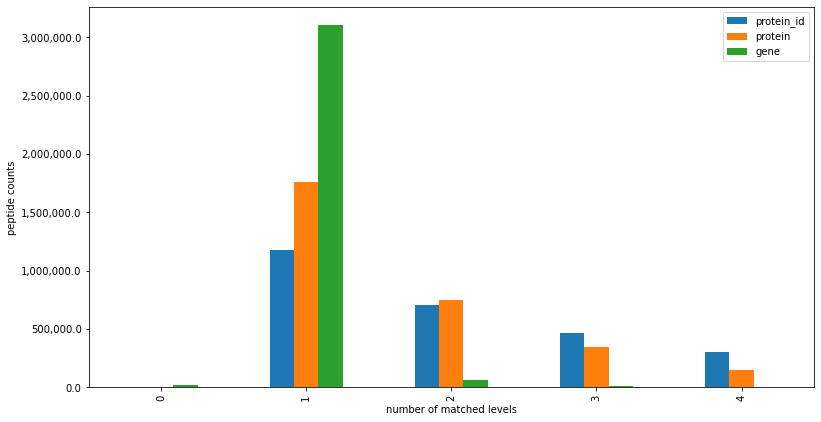

In [46]:
import matplotlib

fig, ax = plt.subplots(figsize=(13, 7))

ax = counts_by_level.iloc[:5].plot(kind="bar", ax=ax)
ax.set_ylabel("peptide counts")
ax.set_xlabel("number of matched levels")
# ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
# ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(['0', '500,000', '1,000,000', '1,500,000', '2,000,000', '2,500,000', '3,000,000', '3,500,000']))
ax.yaxis.set_major_formatter("{x:,}")
# _y_ticks = ax.set_yticklabels(['0', '500,000', '1,000,000', '1,500,000', '2,000,000', '2,500,000', '3,000,000', '3,500,000'])
from vaep.io_images import _savefig

_savefig(fig, folder="figures", name="fasta_top4")

In [47]:
ax.get_yticklabels()

[Text(0, 0.0, '0.0'),
 Text(0, 500000.0, '500,000.0'),
 Text(0, 1000000.0, '1,000,000.0'),
 Text(0, 1500000.0, '1,500,000.0'),
 Text(0, 2000000.0, '2,000,000.0'),
 Text(0, 2500000.0, '2,500,000.0'),
 Text(0, 3000000.0, '3,000,000.0'),
 Text(0, 3500000.0, '3,500,000.0')]

<ipython-input-48-5df54054dcfd>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_yticklabels(['0', '500,000', '1,000,000', '1,500,000', '2,000,000', '2,500,000', '3,000,000', '3,500,000'])


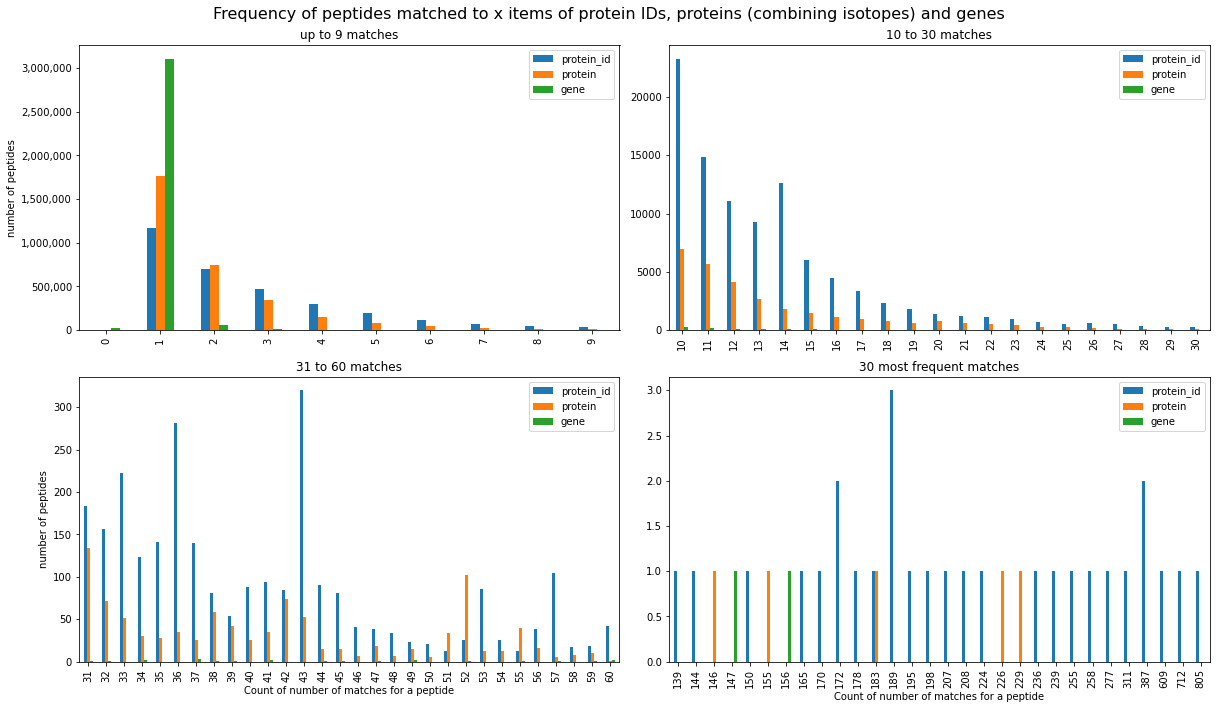

In [48]:
fig, axes = plt.subplots(2, 2, figsize=(17, 10))
axes = axes.flatten()

counts_by_level.iloc[:10].plot(kind="bar", ax=axes[0])
axes[0].set_title("up to 9 matches")
axes[0].set_yticklabels(
    [
        "0",
        "500,000",
        "1,000,000",
        "1,500,000",
        "2,000,000",
        "2,500,000",
        "3,000,000",
        "3,500,000",
    ]
)

_start = 10
for i, _end in enumerate([31, 61], start=1):
    counts_by_level.iloc[_start:_end].plot(kind="bar", ax=axes[i])
    axes[i].set_title(f"{_start} to {_end-1} matches")
    _start = _end

i += 1
counts_by_level.iloc[-30:].plot(kind="bar", ax=axes[i])
axes[i].set_title(f"{30} most frequent matches")


axes = axes.reshape((2, 2))

pad = 5  #  in point
for i in range(2):
    axes[-1, i].set_xlabel("Count of number of matches for a peptide")
    axes[i, 0].set_ylabel("number of peptides")

_ = fig.suptitle(
    "Frequency of peptides matched to x items of protein IDs, proteins (combining isotopes) and genes",
    fontsize=16,
)


fig.tight_layout()
_savefig(fig, folder="figures", name="fasta_mapping_counts")

check for homology of sequences in python?

## Create Automated report

- paragraph in tex for report
- summary table

In [49]:
print(_summary_text)

The theoretical analysis of the fasta files gives an idea about how many possible peptides 
can be expected by cleaving proteins by peptides. The hyperparameters for peptide creation are 
to consider the minimal peptide length to be 7 amino acids, 
to consider a maximum of 2 missed cleavage sites (default in MaxQuant) and 
to not add decoy peptides by reversing peptide sequences. 

A total of 10534 proteins have at least one more isoform. Collapsing isoforms into one protein results in 74416 proteins.
There are 1948 protein IDs (or 1943 proteins) without a gene associated to them in the current faste files.
Most of the 1943 proteins (2.61 percent of the unique proteins) not mapped to a gene name are deleted in the most current version of UniProt. The versioning of the fasta-files has to be investigated.
Proteins are mapped to a total number of genes of 20492.

Considering 2 missed cleavage site(s) there are 3,210,677 unique peptides.


In [50]:
os.makedirs(os.path.dirname(SUMMARY_FILE), exist_ok=True)
with open(SUMMARY_FILE, "w") as f:
    f.write(_summary_text)

## Save mappings as JSON

Each `protein_id` is an entry with the following information:
```
'meta': <fasta-header>
'seq': <protein-sequence>
'peptides': <list of list of peptide sequences: [[0-missed-cleavages, 1-missed-cleavage, 2-missed-cleavage]]>
```

In [53]:
%%time
import json

from config import FN_FASTA_DB

with open(FN_FASTA_DB, "w") as f:
    json.dump(data_fasta, f, indent=4, sort_keys=False)

Wall time: 23.1 s


In [54]:
os.stat(FN_FASTA_DB).st_size / 1024 / 1024

455.389931678772